### Get NBA statistics

In [1]:
import pandas as pd
from nba_api.stats.endpoints import leagueleaders


first_year = 2013
last_year = 2024
leaders_df = []

for year in range(last_year-1, first_year-1, -1):
    season = "{}-{:02}".format(year, (year+1) % 100)
    leaders = leagueleaders.LeagueLeaders(per_mode48="Per48", scope="S", season=season, season_type_all_star="Regular Season")
    leaders_season_df = leaders.get_data_frames()[0]
    leaders_season_df["SEASON"] = season
    leaders_df.append(leaders_season_df)

leaders_df = pd.concat(leaders_df, ignore_index=True)

### Read targets data from csv

In [2]:
with open('target.csv') as csv_file:
    target_names_df = pd.read_csv(csv_file)
    target_names_df = target_names_df.iloc[:15, (last_year-2024):(last_year-first_year)]

for season in target_names_df:
    target_names = target_names_df[season].tolist()    
    idxs = (leaders_df['SEASON'] == season) & (leaders_df['PLAYER'].isin(target_names))
    leaders_df.loc[idxs, 'TARGET'] = 1
    
leaders_df.fillna({'TARGET': 0}, inplace=True)

### Split into train and test data

In [3]:
test_seasons = ['2023-24']
train_df = leaders_df[~leaders_df['SEASON'].isin(test_seasons)].reset_index(drop=True)
test_df = leaders_df[leaders_df['SEASON'].isin(test_seasons)].reset_index(drop=True)

### Prepare vectors of features and targets

In [4]:
from sklearn.preprocessing import MinMaxScaler


features = ['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'REB']
train_data = train_df[features]

scaler = MinMaxScaler()
scaler.fit_transform(train_data)

train_data_norm = scaler.transform(train_data)
train_target = train_df['TARGET'].to_numpy()

test_data_norm, test_target = [], []
for test_season in test_seasons:
    season_df = test_df[test_df['SEASON'] == test_season]

    test_data = season_df[features]
    test_data_norm.append(scaler.transform(test_data))
    test_target.append(season_df['TARGET'].to_numpy())

### Visualize data

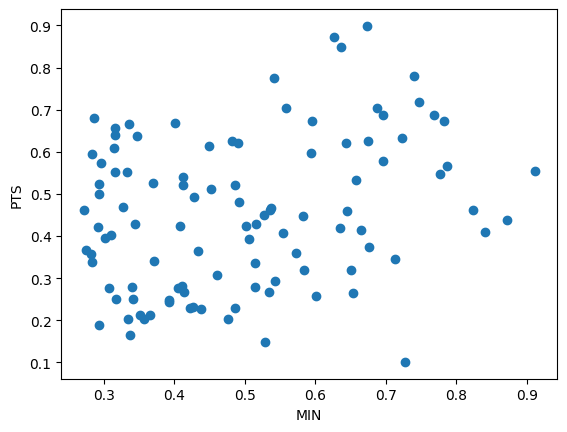

In [5]:
import matplotlib.pyplot as plt


test_season_idx = 0
feature_1_idx = 1
feature_2_idx = 2

plt.scatter(test_data_norm[test_season_idx][:, feature_1_idx], test_data_norm[test_season_idx][:, feature_2_idx])
plt.xlabel(features[feature_1_idx])
plt.ylabel(features[feature_2_idx])
plt.show()

### Train model

In [6]:
from sklearn.ensemble import RandomForestRegressor


clf = RandomForestRegressor()
_ = clf.fit(train_data_norm, train_target)

### Test model

In [7]:
import numpy as np


prediction_df = []
for idx, test_season in enumerate(test_seasons):
    test_season_df = test_df[test_df['SEASON'] == test_season]

    prediction = clf.predict(test_data_norm[idx])
    top_15_idxs = np.argpartition(prediction, -15)[-15:]

    prediction_binary = np.zeros_like(prediction)
    prediction_binary[top_15_idxs] = 1

    prediction_names = test_season_df['PLAYER'][prediction_binary == 1].reset_index(drop=True)
    prediction_names.name = test_season
    prediction_df.append(prediction_names)

prediction_df = pd.concat(prediction_df, axis=1)

### Calculate predictions score

In [8]:
for season in prediction_df:
    prediction = prediction_df[season].to_list()
    target = target_names_df[season].to_list()
    target_teams = np.array([target[i*5:(i+1)*5] for i in range(3)])

    bonus_val = [0, 0, 5, 10, 20, 40]
    
    scores_dict = {}
    for i, name in enumerate(prediction):
        idx_prediction = i // 5
        idx_target = np.where(target_teams == name)[0]

        if idx_target.size == 0:
            score = 0
        elif idx_prediction == idx_target[0]:
            score = 10
        elif abs(idx_prediction - idx_target[0]) == 1:
            score = 8
        elif abs(idx_prediction - idx_target[0]) == 2:
            score = 6

        scores_dict[name] = score
    
    scores = np.array(list(scores_dict.values()))
    score = scores.sum()

    scores_teams = np.array([scores[i*5:(i+1)*5] for i in range(3)])
    bonus = sum(bonus_val[np.count_nonzero(team == 10)] for team in scores_teams)
    score += bonus

    scores_df = pd.DataFrame(scores_dict.items(), columns=['PLAYER', 'SCORE'])

    print('Season', season)
    print(scores_df)
    print('Bonus:', bonus)
    print('Total score:', score)

Season 2023-24
                     PLAYER  SCORE
0               Luka Doncic     10
1   Shai Gilgeous-Alexander     10
2     Giannis Antetokounmpo     10
3             Jalen Brunson      8
4             Stephen Curry      6
5              Nikola Jokic      8
6              Jayson Tatum      8
7           Anthony Edwards     10
8              De'Aaron Fox      0
9              Kevin Durant     10
10             LeBron James     10
11          Zion Williamson      0
12            Anthony Davis      8
13              Paul George      0
14           Paolo Banchero      0
Bonus: 15
Total score: 113


In [9]:
prediction_df

,2023-24
0,Luka Doncic
1,Shai Gilgeous-Alexander
2,Giannis Antetokounmpo
3,Jalen Brunson
4,Stephen Curry
5,Nikola Jokic
6,Jayson Tatum
7,Anthony Edwards
8,De'Aaron Fox
9,Kevin Durant


In [10]:
target_names_df[test_seasons]

,2023-24
0,Giannis Antetokounmpo
1,Luka Doncic
2,Shai Gilgeous-Alexander
3,Nikola Jokic
4,Jayson Tatum
5,Jalen Brunson
6,Anthony Davis
7,Kevin Durant
8,Anthony Edwards
9,Kawhi Leonard
